# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-09")

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


"../data/count_lengths/run_2018-11-09"

# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [2]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,6.24,1,2018-11-10T14:14:07.995,1
2,6.24,1,2018-11-10T14:14:52.978,1
3,6.24,1,2018-11-10T14:14:53.46,1
4,6.24,1,2018-11-10T14:14:53.914,1
5,6.24,1,2018-11-10T14:14:54.39,1
6,6.24,1,2018-11-10T14:14:54.834,1
7,6.24,1,2018-11-10T14:14:55.294,1
8,6.24,1,2018-11-10T14:14:55.744,1
9,6.24,1,2018-11-10T14:14:56.198,1


In [3]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

6.5

# proportion streaming

In [4]:
function handlebound(fn,seconds;bound=true,threshold=0.8)
    if bound && length(seconds) < 3
        return missing
    end
    
    if !bound || (sum(seconds[2:end-1]) > threshold*sum(seconds))
        fn(1:length(seconds))
    else
        fn(2:length(seconds)-1)
    end
end

handlebound (generic function with 1 method)

In [5]:
function streamprop(percepts,seconds;kwds...)
    handlebound(seconds;kwds...) do range
        sum(seconds[range][percepts[range] .== 2]) / sum(seconds[range])
    end
end

streamprop (generic function with 1 method)

In [6]:
function stim_per_second(seconds;kwds...)
    handlebound(seconds;kwds...) do range
        length(range) / sim_length
    end
end
        

stim_per_second (generic function with 1 method)

In [7]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     stim_rate = stim_per_second(:length),
     skew = skewness(log.(:length)),
     kurt = kurtosis(log.(:length)),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m))

,pindex,num_sims,stim_rate,skew,kurt,streamprop,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Int64,Float64,Quantity…,Quantity…,Float64
1,1,150,23.0769,-1.0,-2.0,0.0,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
2,2,150,23.0769,-1.0,-2.0,0.0,5.6,18.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
3,3,150,23.0769,-1.0,-2.0,0.0,5.6,32.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
4,4,150,23.0769,-1.0,-2.0,0.0,5.6,56.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
5,5,150,23.0769,-1.0,-2.0,0.0,5.6,100.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
6,6,150,23.0769,-1.0,-2.0,0.0,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
7,7,150,23.0769,-1.0,-2.0,0.0,5.6,18.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
8,8,150,23.0769,-1.0,-2.0,0.0,5.6,32.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
9,9,150,23.0769,-1.0,-2.0,0.0,5.6,56.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0


WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


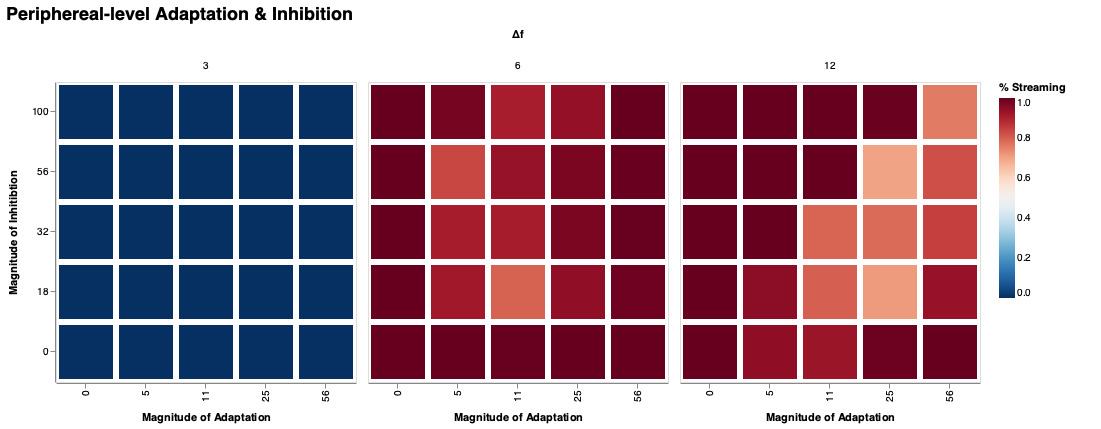

In [13]:
@where(df_summary,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


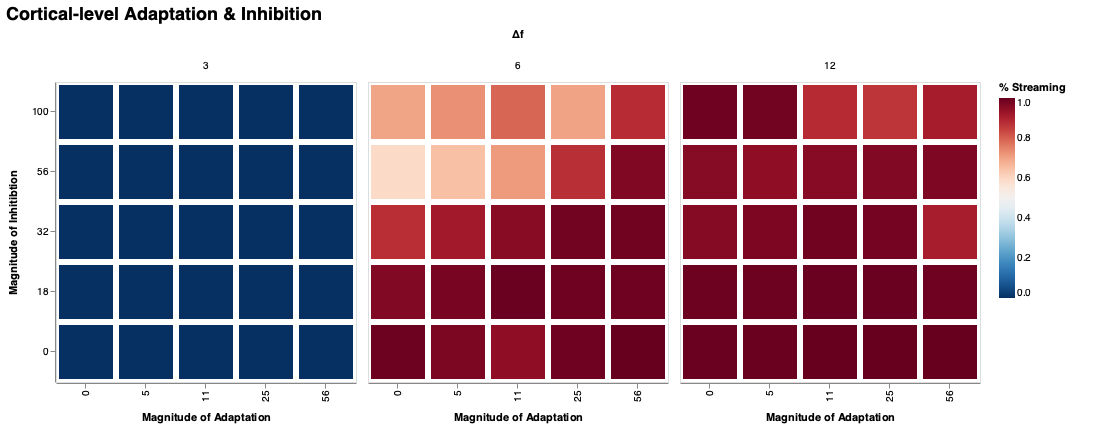

In [14]:
@where(df_summary,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


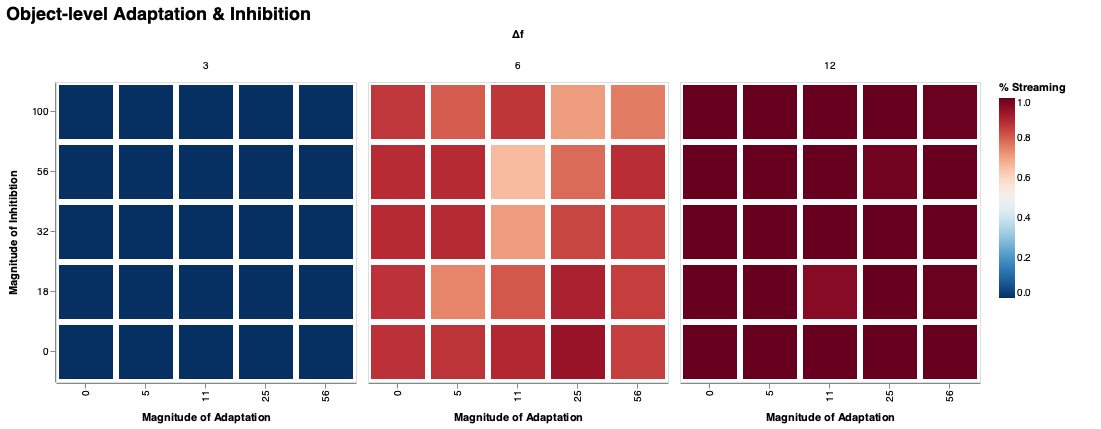

In [15]:
@where(df_summary,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# RMS of streaming selectivity

In [16]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [17]:
function rename_levels_for(df,val)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m,:c_a,:level,val]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, val) = :(rename_levels($df,$val))

In [18]:
df_stream_rms = @linq df_summary |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:Δf,:streamprop) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12)) |>
  rename_levels_for(:stream_rms)

,c_m,c_a,level,stream_rms
,Float64,Float64,String,Float64
1,0.0,0.0,Object,0.204628
2,18.0,0.0,Object,0.203697
3,32.0,0.0,Object,0.211304
4,56.0,0.0,Object,0.210232
5,100.0,0.0,Object,0.199985
6,0.0,5.0,Object,0.202104
7,18.0,5.0,Object,0.144425
8,32.0,5.0,Object,0.211438
9,56.0,5.0,Object,0.21117


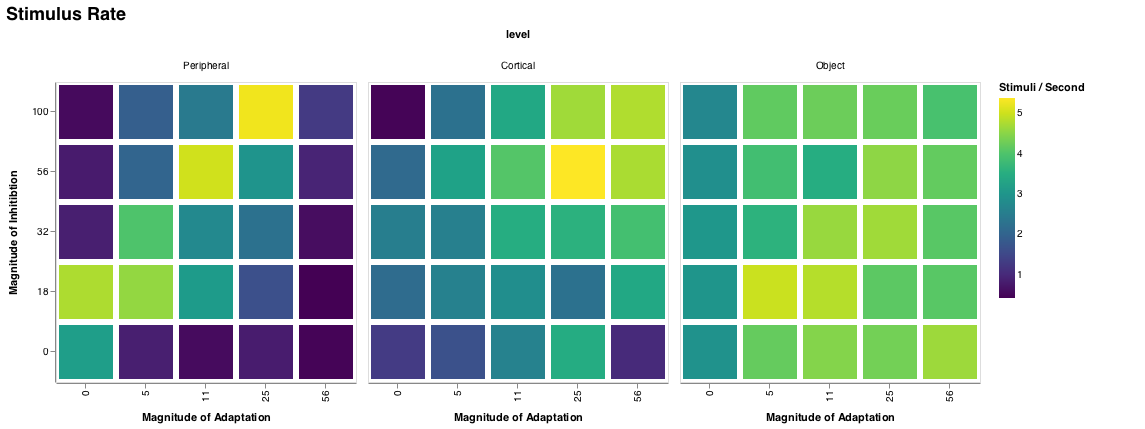

In [111]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

In [28]:
df_stream_rms2 = unstack(df_stream_rms,[:c_m,:c_a],:level,:stream_rms)

,c_m,c_a,Cortical,Object,Peripheral
,Float64,Float64,Float64⍰,Float64⍰,Float64⍰
1,0.0,0.0,0.269701,0.204628,0.274894
2,0.0,5.0,0.258849,0.202104,0.269362
3,0.0,11.0,0.245584,0.213584,0.267732
4,0.0,25.0,0.269583,0.238162,0.273998
5,0.0,56.0,0.274894,0.193531,0.274894
6,18.0,0.0,0.253806,0.203697,0.274894
7,18.0,5.0,0.261259,0.144425,0.224605
8,18.0,11.0,0.271389,0.167374,0.163884
9,18.0,25.0,0.268688,0.221404,0.257285


In [74]:
CSV.write("df_stream_test.csv",df_stream_rms2)

"df_stream_test.csv"

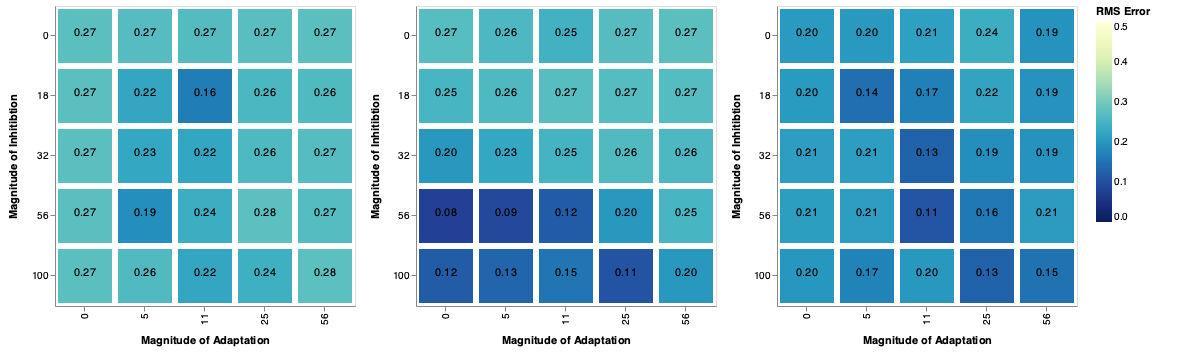

In [29]:
df_stream_rms2 |>
  @vlplot(repeat={column=["Peripheral","Cortical","Object"]},
    config={range={heatmap={scheme="yellowgreenblue"}}}) +
  (@vlplot() +
   @vlplot(:rect, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal",
              axis={title="Magnitude of Inhitibtion"}},
           color={field={repeat="column"}, aggregate="mean", typ="quantitative", sort = "descending",
                  legend={title="RMS Error"}, scale={domain=[0,0.5]}}) +
   @vlplot(:text, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal", 
              axis={title="Magnitude of Inhitibtion"}},
           text={field={repeat="column"}, aggregate="mean", typ="quantitative", format=".2f"}))

# Count

In [19]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

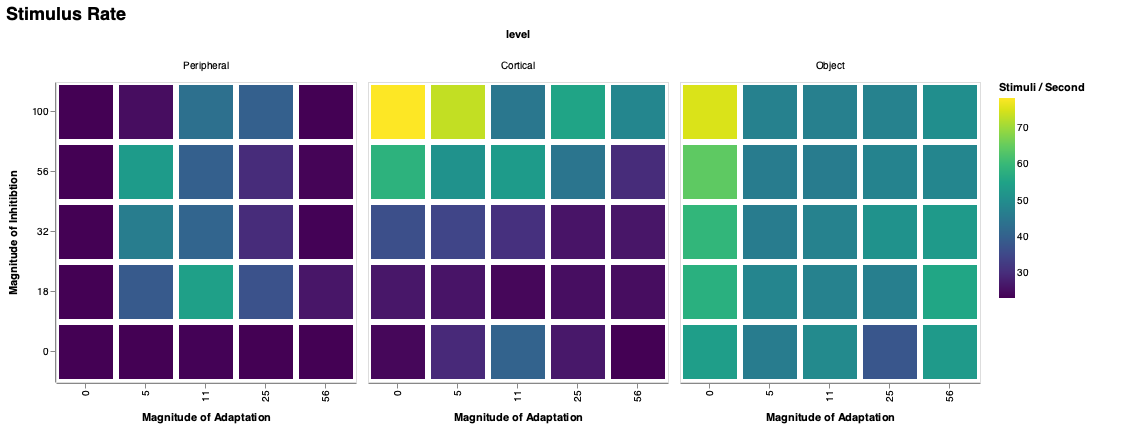

In [49]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Log Normality

In [20]:
df_skew = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:skew) |>
  rename_levels_for(:skew);

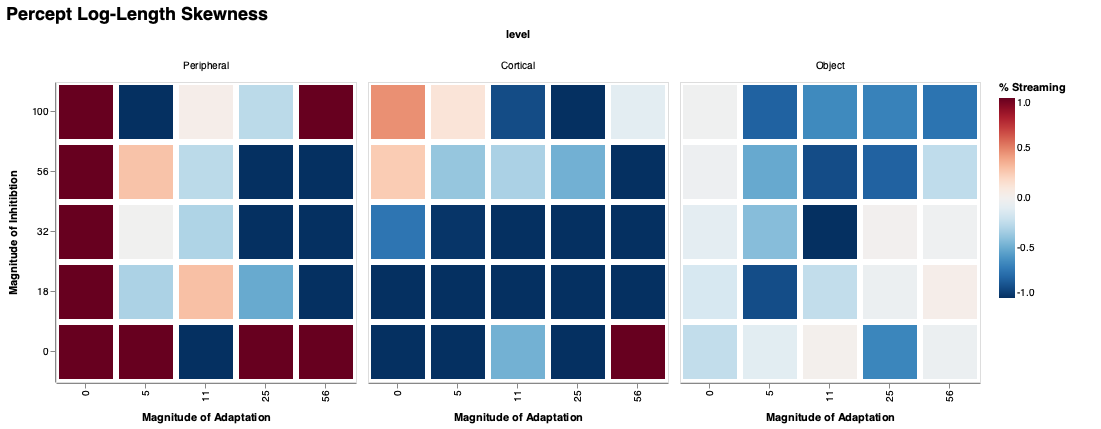

In [21]:
df_skew |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Skewness",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="skew", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-1,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# Kurtosis

In [22]:
df_kurt = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:kurt) |>
  rename_levels_for(:kurt);

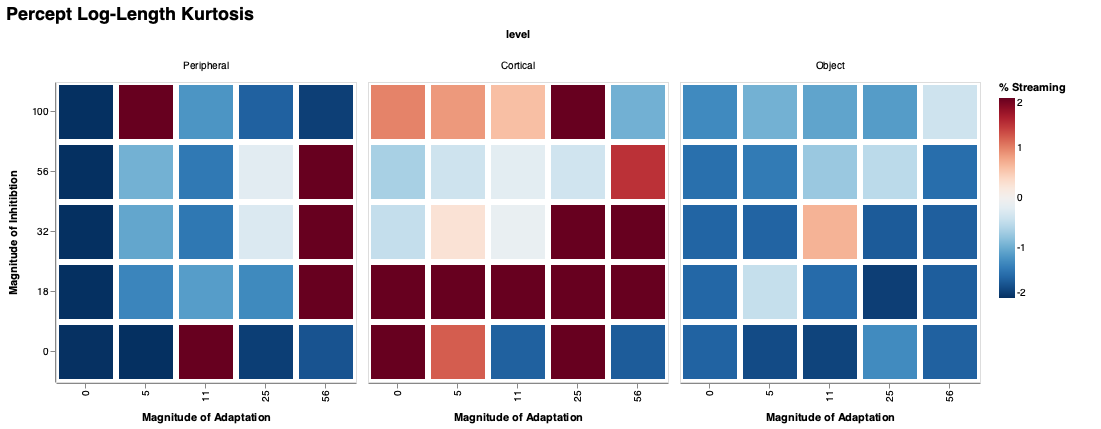

In [23]:
df_kurt |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Kurtosis",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="kurt", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-2,2],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# Overal RMS

In [24]:
rms(x) = any(isnan,x) ? 100 : sqrt(mean(x.^2))

rms (generic function with 1 method)

In [25]:
df_combined = join(df_stream_rms,df_skew,on = [:c_m,:c_a,:level])
df_combined = join(df_combined,df_kurt,on = [:c_m,:c_a,:level])

# for our purposes here we are going to say a kurtosis of 2, a skewness of 1, and a stream deviation of 0.5 are equivalent
# in the final analysis, we should z-score these statistics based on the human data
df_combined = @transform(df_combined,rms = vec(mapslices(rms,[:stream_rms./0.5 :skew./2 :kurt./2],dims=2)))

,c_m,c_a,level,stream_rms,skew,kurt,rms
,Float64,Float64,String,Float64,Float64,Float64,Float64
1,0.0,0.0,Object,0.204628,-0.241161,-1.61236,0.526611
2,18.0,0.0,Object,0.203697,-0.155506,-1.58095,0.515386
3,32.0,0.0,Object,0.211304,-0.0951966,-1.59375,0.521495
4,56.0,0.0,Object,0.210232,-0.0376107,-1.50918,0.498848
5,100.0,0.0,Object,0.199985,-0.0223378,-1.28212,0.436294
6,0.0,5.0,Object,0.202104,-0.102373,-1.79634,0.56942
7,18.0,5.0,Object,0.144425,-0.893027,-0.462733,0.334833
8,32.0,5.0,Object,0.211438,-0.423172,-1.60278,0.537221
9,56.0,5.0,Object,0.21117,-0.511033,-1.41438,0.49792


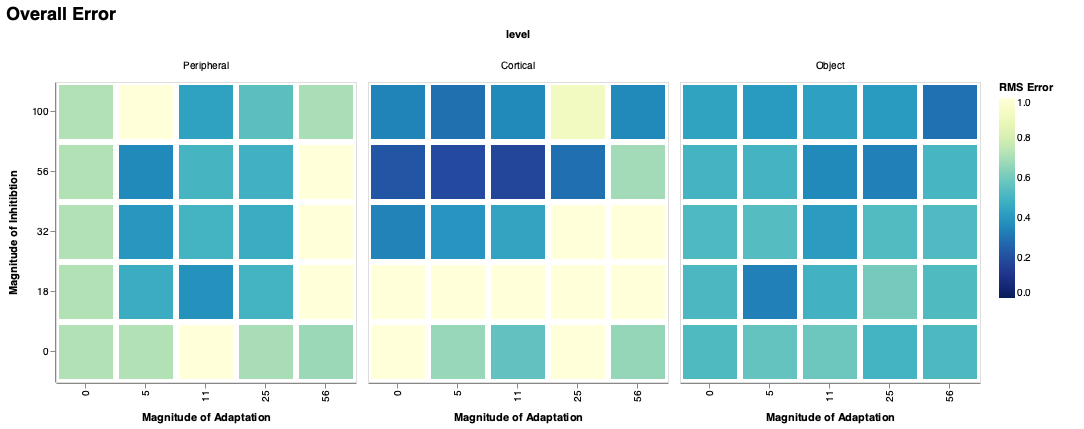

In [26]:
df_combined |>
  @vlplot(:rect, width=300, height=300,
          title={text="Overall Error",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="rms", aggregate="mean", typ="quantitative", sort="descending",
                 legend={title="RMS Error"}, scale={domain = [0,1]}},
          config={range={heatmap={scheme="yellowgreenblue"}},
                  invalidValues="filter"})

# individual trials

In [30]:
selection = @where(params,(abs.(:f_c_m .- 56) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

34

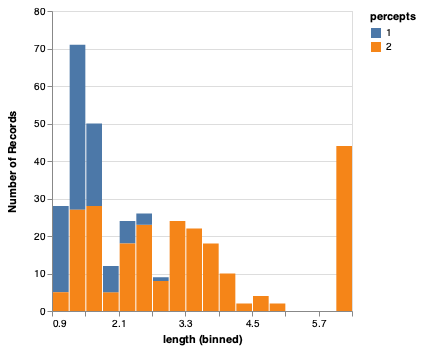

In [31]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.3}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


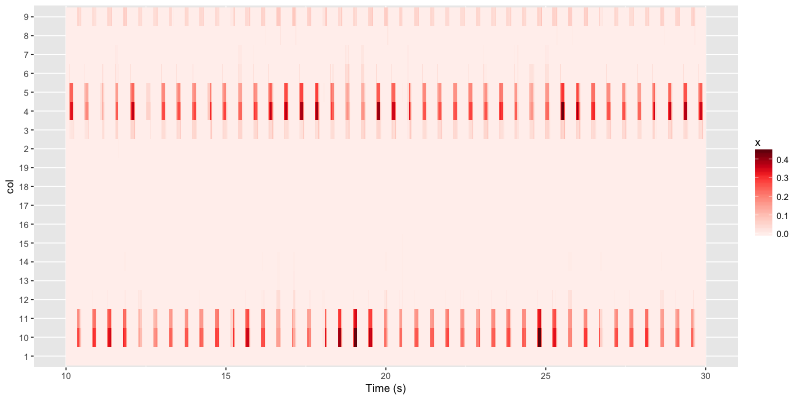

RObject{VecSxp}


In [150]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [32]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

37

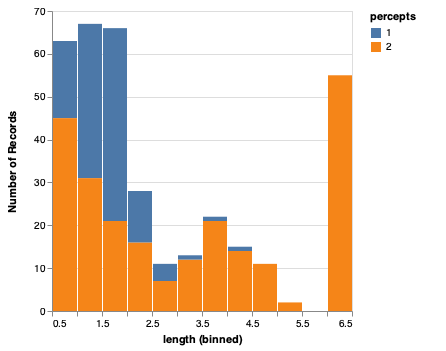

In [34]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


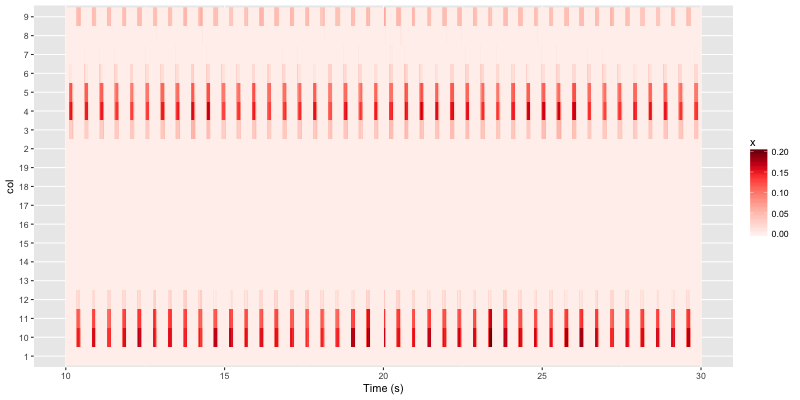

RObject{VecSxp}


In [155]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [156]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

35

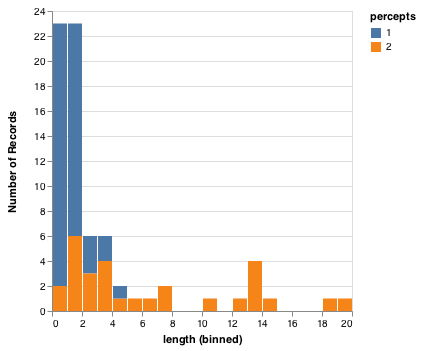

In [157]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


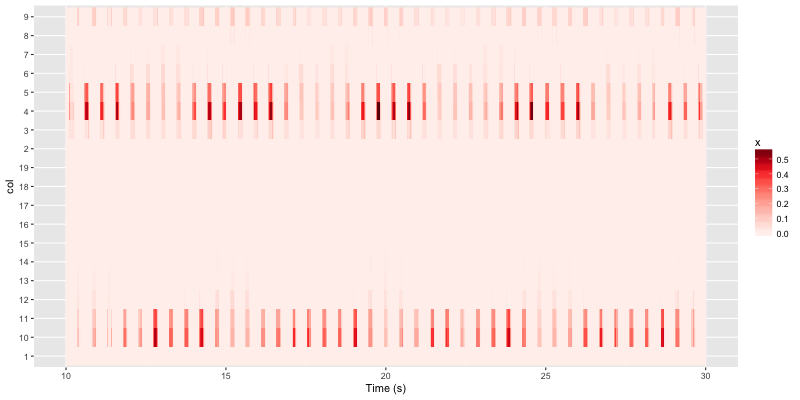

RObject{VecSxp}


In [158]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [35]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

114

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


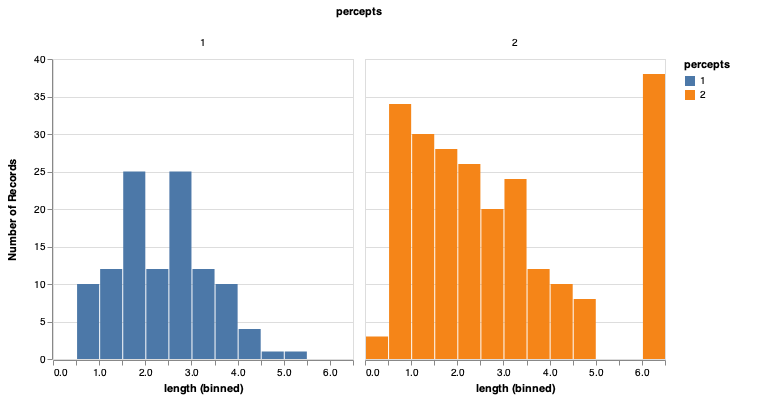

In [39]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


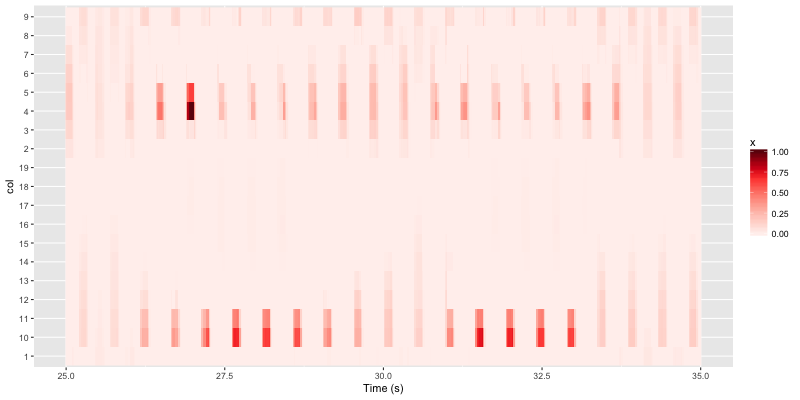

RObject{VecSxp}


In [161]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [162]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 25) .< 1) .& (:Δf .== 6))[:pindex][1]

119

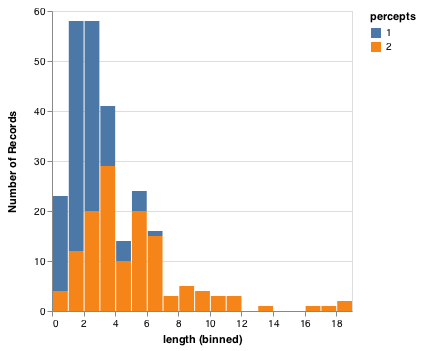

In [163]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [38]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


ArgumentError: ArgumentError: collection must be non-empty

In [50]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

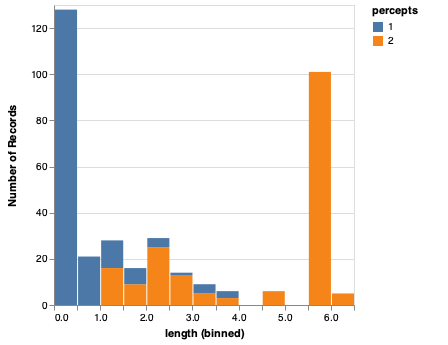

In [51]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


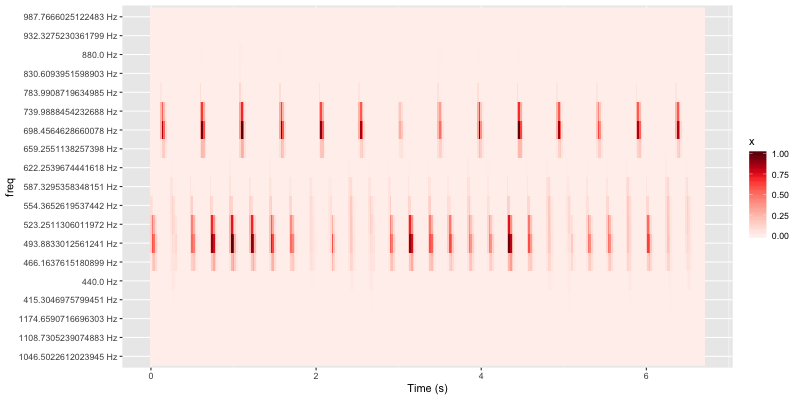

RObject{VecSxp}


In [125]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [126]:
@where(df,:pindex .== selection)

,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,0.48,1,2018-11-10T19:18:24.768,185
2,5.76,2,2018-11-10T19:18:24.768,185
3,0.48,1,2018-11-10T19:18:25.514,185
4,5.76,2,2018-11-10T19:18:25.514,185
5,6.24,2,2018-11-10T19:18:26.298,185
6,0.48,1,2018-11-10T19:18:27.075,185
7,5.76,2,2018-11-10T19:18:27.075,185
8,0.48,1,2018-11-10T19:18:27.89,185
9,1.68,2,2018-11-10T19:18:27.89,185


In [8]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [20]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(14,params_dict,joinpath("..","src","settings.toml"),interactive=true);

Temporal Coherence Analysis: 100%|██████████████████████| Time: 0:00:01
Source Tracking (multi-prior): 100%|████████████████████| Time: 0:00:01


times(fullchan) = 1.2 s:0.1 s:5.5 s
times(maskchan) = 0.39999999999999997 s:0.1 s:6.3 s
val = -0.8240000000000001 s..1.6239999999999999 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8]
val = -0.724 s..1.724 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8]
val = -0.624 s..1.8239999999999998 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8; 8]
val = -0.524 s..1.924 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8; 8; 8]
val = -0.42400000000000004 s..2.024 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8; 8; 8; 8]
val = -0.32399999999999995 s..2.124 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8; 8; 8; 8; 8]
val = -0.22399999999999998 s..2.224 s
times(fullband) = 1.2 s:0.1 s:5.5 s
view(fullband, Axis{:time}(val)) = [8; 8; 8; 8; 8; 8; 8; 8; 

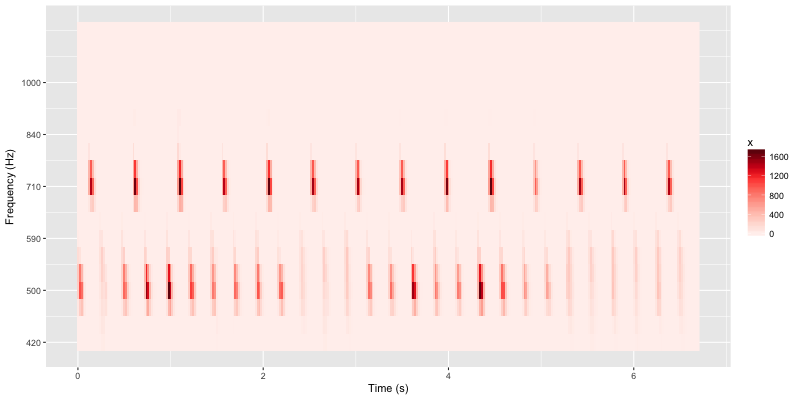

RObject{VecSxp}


In [21]:
rplot(result.primary_source)

In [12]:
result.percepts.counts

([6.0], Bool[false])

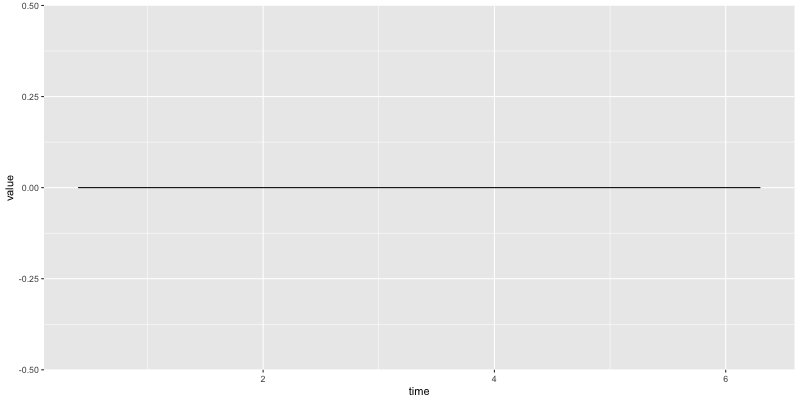

RObject{VecSxp}


In [22]:
rplot(result.percepts.ratio)

I think what's happening is the gap in the B's is being picked up as a 1-object response

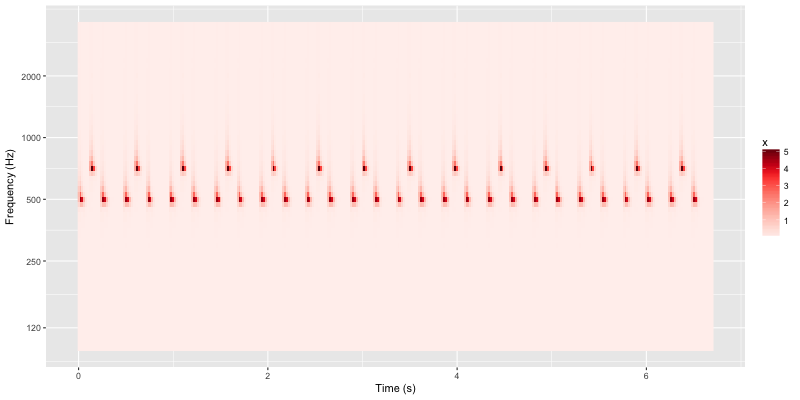

RObject{VecSxp}


In [23]:
rplot(result.input)

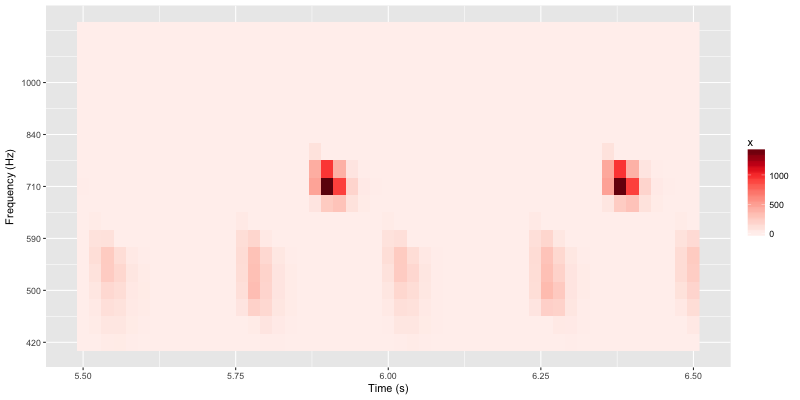

RObject{VecSxp}


In [45]:
rplot(result.primary_source[5.5s .. 6.5s])

In [54]:
ratio, full, mask = bandwidth_ratio(result.primary_source,result.input[:,400Hz .. 1.2kHz],joinpath("..","src","settings.toml"))

fullchan
(sort(levels))[end - 15:end] = [0.151525, 0.194286, 0.260421, 0.39232, 0.473676, 0.477751, 0.706397, 0.737056, 0.927548, 1.21744, 1.22874, 1.28627, 2.48947, 2.75944, 4.57752, 5.18074]
thresh_level = 2.8590074735942723
fixlength(findall(levels .> thresh_level), max_channels, fill=missing) = Union{Missing, Int64}[4, 10, missing, missing, missing, missing, missing, missing, missing, missing]
(sort(levels))[end - 15:end] = [0.151525, 0.194286, 0.260421, 0.39232, 0.473676, 0.477751, 0.706397, 0.737056, 0.927548, 1.21744, 1.22874, 1.28627, 2.48947, 2.75944, 4.57752, 5.18074]
thresh_level = 2.8590073529594973
fixlength(findall(levels .> thresh_level), max_channels, fill=missing) = Union{Missing, Int64}[4, 10, missing, missing, missing, missing, missing, missing, missing, missing]
(sort(levels))[end - 15:end] = [0.151525, 0.194286, 0.260421, 0.39232, 0.473676, 0.477751, 0.706397, 0.737056, 0.927548, 1.21744, 1.22874, 1.28627, 2.48947, 2.75944, 4.57752, 5.18074]
thresh_level = 2.859007

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

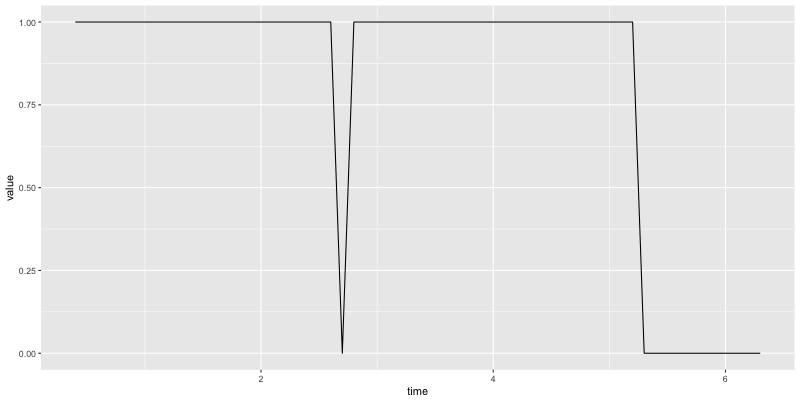

RObject{VecSxp}


In [55]:
rplot(ratio)

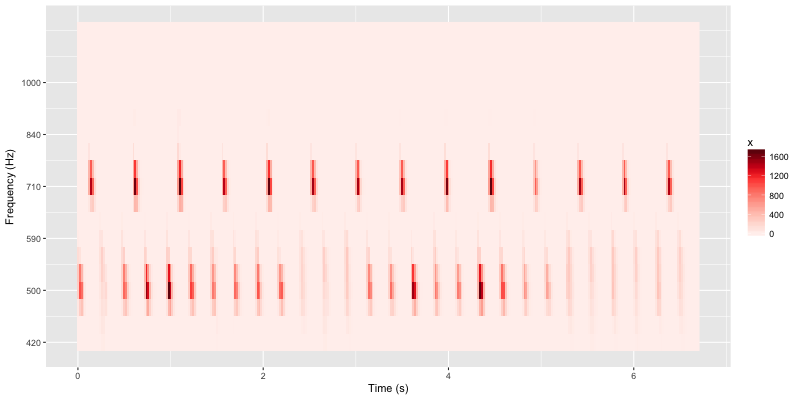

RObject{VecSxp}


In [56]:
rplot(result.primary_source)